# **<center>** COMPUTER VISION PROJECT
## **<center>** ASMA ABIDALLI & SARRA HAMMAMI

## Introduction

The objective of the project is the definition of neural models for the classification of videos related to autism spectrum disorder behaviors and actions.
The SSBD dataset was used which contains 62 clips extracted from YouTube divided into 3 action categories, each containing 20 videos. The 3 main behaviours related to autism are:
1. armFlapping
2. headBanging
3. spinning

## Importing necessary libraries


In [1]:
import os
import cv2
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

#from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras import regularizers

In order to obtain the same results for each execution, it was decided to define a constant seed for the Numpy and Tensorflow libraries

In [2]:
seed_constant = 42
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [3]:
# Apparently you may use different seed values at each stage
seed_value= 42

#Set the `python` built-in pseudo-random generator at a fixed value
random.seed(seed_value)

#Set the `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

# Set the `tensorflow` pseudo-random generator at a fixed value
tf.compat.v1.set_random_seed(seed_value)

# Configure a new global `tensorflow` session
from keras import backend as K
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

1. Data Analysis 

One of the first steps is certainly the visualization of the data to have basic information regarding the structure, thus allowing us to define the best decisions to make regarding the parameters.
The characteristics of the dataset have already been discussed previously, but more precise details can now be provided.
There are 3 categories of ssbd actions and each of them contains an average of 20 videos per category.

In [4]:
## CALCOLARE LA MEDIA DI VIDEO PER CATEGORIA
all_classes_names = os.listdir('C:/Users/abida/Desktop/AIM/ProjetCV/ssbd/')
tot = 0
p = []
for cat in all_classes_names:
  video_files_names_list = os.listdir(f'C:/Users/abida/Desktop/AIM/ProjetCV/ssbd/' + cat)
  num = int(len(video_files_names_list))
  p.append(num)
  tot += num
print(tot)
print(p)
avg = tot / len(all_classes_names)
avg

62
[19, 22, 21]


20.666666666666668

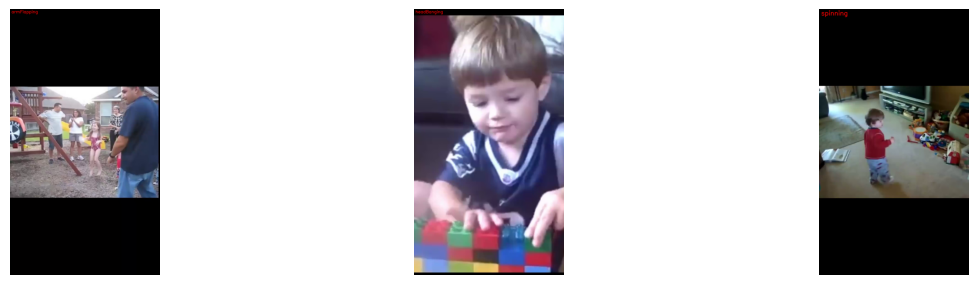

In [5]:
##visualization of the first frame of random videos from each class
plt.figure(figsize = (20, 20))

all_classes_names = os.listdir('C:/Users/abida/Desktop/AIM/ProjetCV/ssbd/') 
## At this point we can define a *for* loop to iterate over the length of the category list
# and thus define the *counter* value to extract each individual category
for counter in range(len(all_classes_names)):

    # A category is extracted based on the *counter*
    selected_class_Name = all_classes_names[counter]

    # Subsequently, the list of all videos of the previously extracted category is extracted
    video_files_names_list = os.listdir(f'C:/Users/abida/Desktop/AIM/ProjetCV/ssbd/{selected_class_Name}')

    # At this point you can decide to randomly choose a video from all the existing ones
    selected_video_file_name = random.choice(video_files_names_list)

    # We use a function from the cv2 library, namely VideoCapture, which allows you to define an element for reading videos
    video_reader = cv2.VideoCapture(f'C:/Users/abida/Desktop/AIM/ProjetCV/ssbd/{selected_class_Name}/{selected_video_file_name}')

    _, bgr_frame = video_reader.read()

    # Once the frame is captured, you need to release the VideoCapture to be able to use it with other videos
    video_reader.release()

    # Next you need to convert the frame from BGR to RGB format to get correct color display
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    # Fundamental step: writing labels on each image to identify the action performed in the video
    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
    
    # Finally the display of the different images
    counter+=1
    plt.subplot(5, 4, counter);plt.imshow(rgb_frame);plt.axis('off')

# 2. Data Preprocessing 

To be able to work with this type of data it is necessary to carry out some preliminary cleaning, correction and transformation operations. it is in fact necessary to normalize the frames extracted from each video, above all to reduce the computational cost.

In [6]:
## INITIALIZATION OF CONSTANTS FOR DIMENSIONALITY AND NUMBER OF FRAMES PER VIDEO

# First define the new size on which to resize the frames
# It was decided to use this to maintain the rectangular shape of the videos and because larger dimensions did not favor the use of too many models
# complex due to high RAM usage
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 96

# You also define the number of frames you want to extract from each video, the greater the number of frames the more precise the model will be,
# but at the same time the computational cost increases
SEQUENCE_LENGTH = 50

All the parameters just defined can be increased to obtain better results, at the same time a stalemate situation will be reached in which no performance improvement can be obtained but only a computationally expensive process.

In [7]:
## DEFINITION OF PATH TO THE DATASET AND LIST WITH THE NAMES OF THE CATEGORIES

# Directory to data
DATASET_DIR = 'C:/Users/abida/Desktop/AIM/ProjetCV/ssbd/'
# List with category names
all_classes_names = os.listdir('C:/Users/abida/Desktop/AIM/ProjetCV/ssbd')
CLASSES_LIST = all_classes_names
CLASSES_LIST

['armFlapping', 'headBanging', 'spinning']

The next step is to create a function that allows you to extract frames from videos, resize them using the parameters just defined and normalize them in a range (0.1) by dividing each single pixel by the value 255.

This is a function that presents the directory of the dataset with the videos as the only input argument, and as output a list containing the resized and normalized frames. It is underlined that the function just mentioned will be used within the next function.

In [8]:
def frames_extraction(video_path):

    # We initialize an empty list that will contain the frames
    frames_list = []
    
    # The VideoCapture function previously used to "read" videos is resumed
    video_reader = cv2.VideoCapture(video_path)

    # At this point you need to extract the total number of frames per video, this is because
    # frames must be extracted for the entire length of the videos and not just at the beginning
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # In this way the video is divided into equal frame intervals
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    # Iterates a for loop that will choose 20 frames per video, resize them and normalize them individually,
    # and then add them to the previously initialized list
    for frame_counter in range(SEQUENCE_LENGTH):

        # In this way the 20 frames are selected homogeneously across the entire video
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # You use the command to play videos
        # The *success* element is also defined because the reading element also outputs a boolean value
        # which provides the outcome of the procedure
        success, frame = video_reader.read()

        # In fact, in this way you can check whether the reading was successful
        if not success:
            break

        # Once the frames are extracted, you need to resize them to the dimensions you choose yourself
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        # Finally we normalize each single frame by dividing it by 255 so that the value of each single pixel is between 0 and 1
        normalized_frame = resized_frame / 255
        
        # After having carried out all the procedures necessary to obtain elements that are easier to read, analyze and understand,
        # it is possible to add them to the list of frames which will constitute the main element of the starting dataset
        frames_list.append(normalized_frame)
    
    # As mentioned above, after each reading you need to release the VideoCapture element so that it can be used on other videos
    video_reader.release()

    # Being a function it is necessary to provide a return command regarding the list of frames
    return frames_list

### **<font style="color:rgb(134,19,348)">Dataset Creation Function</font>**


The create_dataset() function is implemented which will iterate through all the classes specified in the CLASSES_LIST constant and will call the frame_extraction() function on each video file of the selected classes to finally return the frames (features), the class index (labels) and the path to the video file (video_files_paths).

In [9]:
def create_dataset():

    # I declare the lists in which I will store features, labels and filepaths
    features = []
    labels = []
    video_files_paths = []
    
    # Iterate through all classes of the CLASSES_LIST variable
    for class_index, class_name in enumerate(CLASSES_LIST):
        
        print(f'Extracting Data of Class: {class_name}')
        
        # List of videos in the specific class
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        
        # Iterate through the class file list
        for file_name in files_list:
            
            # I extract the video path
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            # I extract the frames of each video with the function created previously
            frames = frames_extraction(video_file_path)

            # I verify that the extracted frames of each video correspond to the SEQUENCE_LENGHT variable
            if len(frames) == SEQUENCE_LENGTH:

                # I add the extracted elements to the respective lists
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)
 
    # Return the frames, classes, and filepaths
    return features, labels, video_files_paths

The function created above is applied by saving the elements by working with the CPU, which is much more efficient in this type of operations.

In [10]:
with tf.device('CPU:0'):
  features, labels, video_files_paths = create_dataset()

Extracting Data of Class: armFlapping
Extracting Data of Class: headBanging
Extracting Data of Class: spinning


After creating the elements of interest, they are saved in the GPU, given that it is the most performing in the training of the various models.

In [11]:
with tf.device('GPU:0'):
  features = features*1
  labels = labels*1
  video_files_paths = video_files_paths*1

Once the function has been implemented and applied, it is necessary to transform the features element from a list to an array with dimensionality (video number, frame number, dimensions).

In [12]:
features = np.asarray(features)

The dimensionality of the created features element is also shown.

In [13]:
features.shape, features.size

((62, 50, 96, 64, 3), 57139200)

Same procedure for labels, i.e. the labels, saved in a vector with a length equal to the number of videos present.

In [14]:
labels = np.array(labels)
labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

Finally, you need to create a label array via one_hot_encoded conversion.

In [15]:
one_hot_encoded_labels = to_categorical(labels)

#3. Division of data into Training and Validation Sets

Once the actual dataset has been created from which it will be possible to train the different models to be used for classifying videos with their own labels, it is necessary to divide the data into Training and Validation Sets. They respectively represent the portion of data to improve performance of the model and to evaluate performance on new data.

It was also decided to include as subdivision parameters both the *shuffle* option, which allows you to reduce the bias, and the *stratify* option, which allows you to maintain the same distribution of categories in the two new datasets. Finally, the same seed defined previously was maintained and a percentage of approximately 25% of the starting set was decided as the size of the validation set.

In [16]:
## FEATURE SET DIVISION

# To check for stratification, the function is executed using the non-one-hot-encoded label vector so as to be more interpretable.

features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size = 0.25, shuffle = True,
                                                                           random_state = seed_constant, stratify = labels)

In this way the correct homogeneity of the classes in the two data sets is verified

In [17]:
import collections
collections.Counter(labels_train)

Counter({2: 16, 0: 14, 1: 16})

In [18]:
collections.Counter(labels_test)

Counter({1: 6, 2: 5, 0: 5})

It turns out that the frequencies are very similar so you are satisfied with the division and can apply it using the label matrix created previously.

In [19]:
## FEATURE SET DIVISION

# We keep 75% of the observations for the training set and 25% for the validation set

features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels,
                                                                            test_size = 0.25, shuffle = True,
                                                                            random_state = seed_constant,
                                                                            stratify = labels)

#4. Implementation of classification models: LRCN approach

For this particular type of data, it was decided to try a solution that combines two different types of neural networks: Convolutional Neural Network (CNN) and Long short-Term Memory (LSTM). In combining these two strategies, CNN layers are used to extract spatial features from frames, and each of them is subsequently fed to the LSTM layer for temporal sequence modeling. A Long-Term Recurrent Convolutional Network is obtained which directly learns the space-time characteristics leading to the construction of a robust model.

Another important feature of the network structure is the use of the *TimeDistributed* layer which is essential in situations of this type; in fact it allows you to apply the same layer to each frame of the video independently. Essentially it adds the *number of frames* parameter to the layer input, i.e. it replaces the input of a single frame with the input of the entire video.


### Model structure

The first model that we decided to define is relatively simple: it has a *Conv2D* layer with *TimeDistributed* and 64 filters of 4x4 size. Subsequently, a *GlobalMaxPooling2D* layer is inserted which allows you to create the input suitable for the last layer of *LSTM*. Finally, we have a *Dense* layer with a softmax activation function which, through a probability between 0 and 1, provides us with the prediction of the action performed within the video.

In [20]:
def create_LRCN_model_basic():

    # Initialize a sequential pattern
    model = Sequential()
    
    # First Conv2D layer with 64 filters of 4x4 size and 'relu' activation function
    model.add(TimeDistributed(Conv2D(64, (4, 4), padding='same',activation = 'relu'),
                              input_shape = (SEQUENCE_LENGTH, IMAGE_WIDTH, IMAGE_HEIGHT,3)))

    # GlobalMaxPooling2D layer
    model.add(TimeDistributed(GlobalMaxPooling2D()))

    # LSTM layer with 64 neurons and 'tanh' activation function
    model.add(LSTM(64, activation = 'tanh'))

    # Finally Dense layer with 'softmax' activation function to reduce the output to the number of categories equal to 19
    model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))

    model.summary()
    
    return model

In [21]:
# Create the model by calling the previous function

LRCN_model_basic = create_LRCN_model_basic()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 50, 96, 64, 64)    3136      
 ributed)                                                        
                                                                 
 time_distributed_1 (TimeDi  (None, 50, 64)            0         
 stributed)                                                      
                                                                 
 lstm (LSTM)                 (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 3)                 195       
                                                                 
Total params: 36355 (142.01 KB)
Trainable params: 36355 (142.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [22]:
# Print the structure of the model

plot_model(LRCN_model_basic, to_file = 'LRCN_basic_model_structure_plot.png', show_shapes = True, show_layer_names = True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [23]:
## MODEL PARAMETERS AND FITTING

# An Early Stopping parameter is created, stopping the algorithm when the validation loss does not decrease after more than 15 epochs
early_stopping_callback = EarlyStopping(monitor = 'loss', patience = 5, mode = 'min', restore_best_weights = True)
 
# The compile command is used to define the loss metric, the metrics to optimize and which method to apply; in
# in this case we chose to use "Adam", i.e. stochastic gradient descent
LRCN_model_basic.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Once all the parameters of interest have been defined, you can start training the model on the training set and directly evaluate them
# performance on validation after each epoch. *shuffle* is also inserted to further reduce the bias during
# the training
LRCN_model_basic_training_history = LRCN_model_basic.fit(x = features_train, y = labels_train, epochs = 10, batch_size = 64,
                                                         shuffle = True, callbacks = [early_stopping_callback],
                                                         validation_data = (features_test, labels_test))

Epoch 1/10
1/1 [==============================] - 373s 373s/step - loss: 1.1075 - accuracy: 0.3478 - val_loss: 1.1085 - val_accuracy: 0.3750
Epoch 2/10
1/1 [==============================] - 674s 674s/step - loss: 1.0899 - accuracy: 0.3478 - val_loss: 1.1182 - val_accuracy: 0.3125
Epoch 3/10
1/1 [==============================] - 217s 217s/step - loss: 1.0888 - accuracy: 0.3478 - val_loss: 1.1159 - val_accuracy: 0.3125
Epoch 4/10


In [ ]:
# The performance of the best estimated model is taken

model_evaluation_history = LRCN_model_basic.evaluate(features_test, labels_test)

1/1 [==============================] - 2s 2s/step - loss: 2.0506 - accuracy: 0.5625


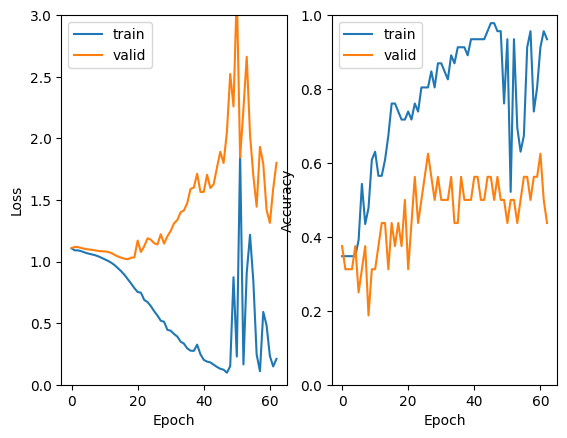

In [ ]:
##  METRICS VISUALIZATION
plt.subplot(1, 2, 1)
plt.plot(LRCN_model_basic_training_history.history['loss'])
plt.plot(LRCN_model_basic_training_history.history['val_loss'])
plt.ylim([0, 3.0])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'valid'])

plt.subplot(1, 2, 2)
plt.plot(LRCN_model_basic_training_history.history['accuracy'])
plt.plot(LRCN_model_basic_training_history.history['val_accuracy'])
plt.ylim([0, 1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'valid'])

The performance of this decidedly basic model is not exceptional but it was to be expected. In the face of a generally high accuracy on training, there corresponds a value of accuracy on validation that is decidedly inadequate with the risk of overfitting. We decide to define a more complex model.

In [ ]:
#Saving the model
# from keras.models import load_model
LRCN_model_basic.save('C:/Users/abida/Desktop/AIM/ProjetCV/ssbd_classification/LRCN_basic_64_150_DEF.h5')

c:\Users\abida\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Structure of the second model

The second model that we decided to define is certainly more complex: it has a *Conv2D* layer with 64 filters with *TimeDistributed*, followed by a *MaxPooling2D* and *Dropout* layer with a value of 0.25. Subsequently, a further *Conv2D* layer with 128 filters is inserted followed by *MaxPooling2D* and the *Dropout* layer. Then a final layer of *Conv2D* with 256 filters is inserted, followed this time by a *GlobalMaxPooling2D*.

At this point a last layer of *LSTM* with Ridge regularizer and a number of neurons equal to 256 was inserted. Finally, there is a layer of *Flatten* and *Dense* with a softmax activation function which, through a probability between 0 and 1, it provides us with the prediction of the action performed within the video.

In [ ]:
def create_LRCN_model():

    # A sequential model is initialized
    model = Sequential()
    
    # First layer of Conv2D with 64 filters of 4x4 size with Dropout option to make neurons independent with a rate
    # by 30%, with 'relu' activation function and MaxPooling2D layer
    model.add(TimeDistributed(Conv2D(64, (4, 4), padding='same',activation = 'relu'),
                              input_shape = (SEQUENCE_LENGTH, IMAGE_WIDTH, IMAGE_HEIGHT, 3)))
    model.add(TimeDistributed(MaxPooling2D((4,4))))
    model.add(TimeDistributed(Dropout(0.3)))
    
    # Second layer of Conv2D with 128 filters of 4x4 size with Dropout option to make neurons independent with a rate
    # by 30%, with 'relu' activation function and MaxPooling2D layer
    model.add(TimeDistributed(Conv2D(128, (4, 4), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((4,4))))
    model.add(TimeDistributed(Dropout(0.3)))
    
    # Third layer of Conv2D with 256 filters of 2x2 size with Dropout option to make neurons independent with a rate
    # by 30%, with 'relu' activation function and GlobalMaxPooling2D layer
    model.add(TimeDistributed(Conv2D(256, (2, 2), padding='same',activation = 'relu')))
    model.add(TimeDistributed(GlobalMaxPooling2D()))

    # Last LSTM layer with 256 neurons, Ridge regularizer and 'relu' activation function
    model.add(LSTM(256, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.1)))
   
    # Flatten layer
    model.add(Flatten())

    # Finally Dense layer with 'softmax' activation function to reduce the output to the number of categories equal to 19
    model.add(Dense(len(CLASSES_LIST), activation = 'softmax')) #kernel_regularizer='l1_l2',

    model.summary()
    
    return model

In [ ]:
# generate the model

LRCN_model = create_LRCN_model()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_2 (TimeDi  (None, 20, 96, 64, 64)    3136      
 stributed)                                                      
                                                                 
 time_distributed_3 (TimeDi  (None, 20, 24, 16, 64)    0         
 stributed)                                                      
                                                                 
 time_distributed_4 (TimeDi  (None, 20, 24, 16, 64)    0         
 stributed)                                                      
                                                                 
 time_distributed_5 (TimeDi  (None, 20, 24, 16, 128)   131200    
 stributed)                                                      
                                                                 
 time_distributed_6 (TimeDi  (None, 20, 6, 4, 128)    

In [ ]:
plot_model(LRCN_model, to_file = 'LRCN_model_structure_plot.png', show_shapes = True, show_layer_names = True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [ ]:
## MODEL PARAMETERS AND FITTING

# An Early Stopping parameter is created, stopping the algorithm when the validation loss does not decrease after more than 10 epochs
early_stopping_callback = EarlyStopping(monitor = 'loss', patience = 30, mode = 'min', restore_best_weights = True)

# The compile command is used to define the loss metric, the metrics to optimize and which method to apply; in
# in this case we chose to use "Adam", i.e. stochastic gradient descent
LRCN_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Once all the parameters of interest have been defined, you can start training the model on the training set and directly evaluate them
# performance on validation after each epoch. *shuffle* is also inserted to further reduce the bias during
# the training
LRCN_model_training_history = LRCN_model.fit(x = features_train, y = labels_train, epochs = 150, batch_size = 32,
                                             shuffle = True, callbacks = [early_stopping_callback],
                                             validation_data = (features_test, labels_test))

Epoch 1/150
2/2 [==============================] - 54s 13s/step - loss: 41.5261 - accuracy: 0.3478 - val_loss: 38.5643 - val_accuracy: 0.5625
Epoch 2/150
2/2 [==============================] - 28s 11s/step - loss: 38.0980 - accuracy: 0.5000 - val_loss: 35.3565 - val_accuracy: 0.3125
Epoch 3/150
2/2 [==============================] - 28s 11s/step - loss: 34.8780 - accuracy: 0.4348 - val_loss: 32.3321 - val_accuracy: 0.3125
Epoch 4/150
2/2 [==============================] - 28s 10s/step - loss: 31.8817 - accuracy: 0.3261 - val_loss: 29.5003 - val_accuracy: 0.5625
Epoch 5/150
2/2 [==============================] - 27s 11s/step - loss: 29.0765 - accuracy: 0.3913 - val_loss: 26.8539 - val_accuracy: 0.5000
Epoch 6/150
2/2 [==============================] - 27s 11s/step - loss: 26.4485 - accuracy: 0.5652 - val_loss: 24.3813 - val_accuracy: 0.5625
Epoch 7/150
2/2 [==============================] - 27s 11s/step - loss: 23.9802 - accuracy: 0.5870 - val_loss: 22.0672 - val_accuracy: 0.5625
Epoch 

In [ ]:
#the best model found is taken

model_evaluation_history = LRCN_model.evaluate(features_test, labels_test)

1/1 [==============================] - 2s 2s/step - loss: 4.2308 - accuracy: 0.6875


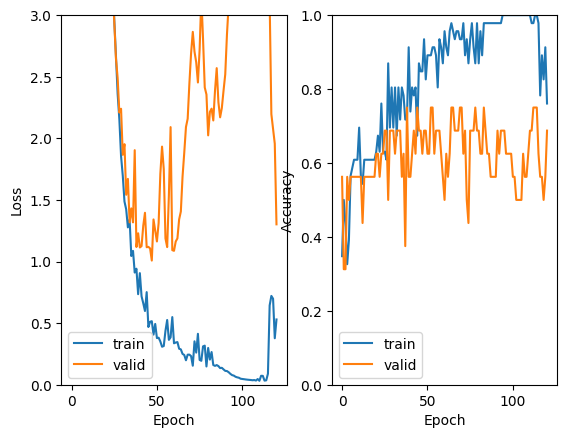

In [ ]:
## PLOT TO VIEW THE TREND OF THE MODEL BASED ON THE METRICS OF INTEREST

plt.subplot(1, 2, 1)
plt.plot(LRCN_model_training_history.history['loss'])
plt.plot(LRCN_model_training_history.history['val_loss'])
plt.ylim([0, 3.0])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'valid'])

plt.subplot(1, 2, 2)
plt.plot(LRCN_model_training_history.history['accuracy'])
plt.plot(LRCN_model_training_history.history['val_accuracy'])
plt.ylim([0, 1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'valid'])

In [ ]:
#saving the model
# from keras.models import load_model
LRCN_model.save('C:/Users/abida/Desktop/AIM/ProjetCV/ssbd_classification/LRCN_Conv_LSTM_64_DEF.h5')